In [1]:
# importa paquetes
import util_mlp_cnn_ESU23
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary

c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define hardware
device = torch.device('cpu')

#### 1. Preparamos los datos disponibles como dos datasets de imágenes
- tr_dataset: 60k imágenes para entrenar el modelo
- ts_dataset: 10k imágenes para testar el modelo

In [3]:
# Datos para entrenamiento
tr_imagefile = './data/MNIST/raw/train-images-idx3-ubyte'
tr_labelfile = './data/MNIST/raw/train-labels-idx1-ubyte'

# Datos de test
ts_imagefile = './data/MNIST/raw/t10k-images-idx3-ubyte'
ts_labelfile = './data/MNIST/raw/t10k-labels-idx1-ubyte'

# Crea los datasets de tr y ts
tr_dataset = util_mlp_cnn_ESU23.MiDataset(tr_imagefile, tr_labelfile)
ts_dataset = util_mlp_cnn_ESU23.MiDataset(ts_imagefile, ts_labelfile)

#### 2. Preparamos los cargadores para acceder realmente a los datos

In [4]:
# Define TAMAÑO DEL LOTE y crea los cargadores de datos 
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=tr_dataset, 
                                           batch_size = batch_size,
                                           shuffle = False)  # normalmente a True
test_loader = torch.utils.data.DataLoader(dataset=ts_dataset, 
                                           batch_size = batch_size,
                                           shuffle = False)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


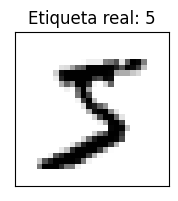

In [5]:
# prueba que está todo ok
img, label = train_features[0].squeeze(), train_labels[0]
fig = plt.figure(1,figsize=(2, 2))
plt.imshow(img, cmap="binary")
plt.title(f"Etiqueta real: {label}")
plt.xticks([]); plt.yticks([])
plt.show()

#### 3. Define la red neuronal (MLP)

In [6]:
# arquitectura de la red (MLP dos capas)
class RedNeuronal(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RedNeuronal, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.sigmo1 = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        out = self.l1(x)
        out = self.sigmo1(out)
        out = self.l2(out)
        out = self.softmax(out)
        return out

# inicializa la red
model = RedNeuronal(input_size = 28*28, hidden_size=100, num_classes=10)

# Muestra la red
print("Estructura de la red:")
for param_tensor in model.state_dict():
    print(f'{param_tensor} \t {model.state_dict()[param_tensor].size()}')

# resumen nº de params en cada capa
print(summary(model))

Estructura de la red:
l1.weight 	 torch.Size([100, 784])
l1.bias 	 torch.Size([100])
l2.weight 	 torch.Size([10, 100])
l2.bias 	 torch.Size([10])
Layer (type:depth-idx)                   Param #
RedNeuronal                              --
├─Linear: 1-1                            78,500
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            1,010
├─Softmax: 1-4                           --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0


#### 4. Ajusta la red iterando el nº de épocas indicado

In [7]:
# función de pérdida
funcion_perdida = nn.CrossEntropyLoss()
learning_rate = 0.001
n_epochs = 3
optimizador = torch.optim.Adam(model.parameters(), lr = learning_rate)

c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Época: 1/3  - Step: 200/600 :: loss = 1.772883653640747
Época: 1/3  - Step: 400/600 :: loss = 1.8180820941925049
Época: 1/3  - Step: 600/600 :: loss = 1.647646427154541
Época: 2/3  - Step: 200/600 :: loss = 1.6279116868972778
Época: 2/3  - Step: 400/600 :: loss = 1.5823742151260376
Época: 2/3  - Step: 600/600 :: loss = 1.52457594871521
Época: 3/3  - Step: 200/600 :: loss = 1.5643815994262695
Época: 3/3  - Step: 400/600 :: loss = 1.553745150566101
Época: 3/3  - Step: 600/600 :: loss = 1.5025124549865723
Modelo ajustado en 3 épocas.


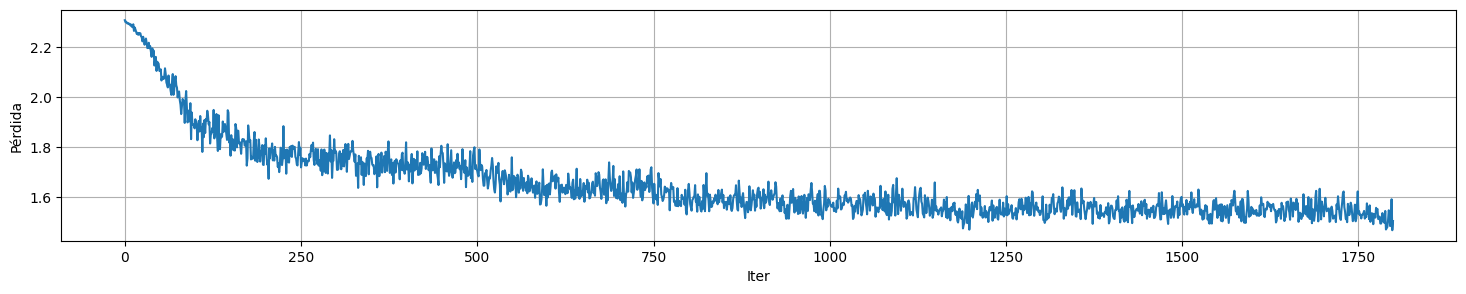

In [8]:
# Bucle de ajuste de los parámetros del modelo
n_total_steps = len(train_loader)
tr_eval_loss = np.zeros(n_epochs * n_total_steps)
k=0
for epoch in range(n_epochs):
    for i, (imgs, etqs) in enumerate(train_loader):
        imgs = imgs.reshape(-1, 28*28).to(device)
        etqs = etqs.to(device)
        
        # forward
        outputs = model(imgs)
        loss = funcion_perdida(outputs, etqs)
        tr_eval_loss[k] = loss
        k+=1

        # backward
        optimizador.zero_grad()
        loss.backward()
        optimizador.step()

        if (i+1) % 200 == 0:
            print(f'Época: {epoch+1}/{n_epochs} '
                  f' - Step: {i+1}/{n_total_steps} :: loss = {loss.item()}')


print(f'Modelo ajustado en {n_epochs} épocas.')
fig = plt.figure(1,figsize=(18, 3))
plt.plot(tr_eval_loss)
plt.xlabel('Iter')
plt.ylabel('Pérdida')
plt.grid()
plt.show()

#### 5. Calcula % aciertos y matrices de confusión en TR y TS

TR ----------
   Correctas (TR):56271 Incorrectas(TR):3729
   Aciertos (TR): 93.785 %
TS ----------
   Correctas (TS):9353 Incorrectas(TS):647
   Aciertos (TS): 93.53 %


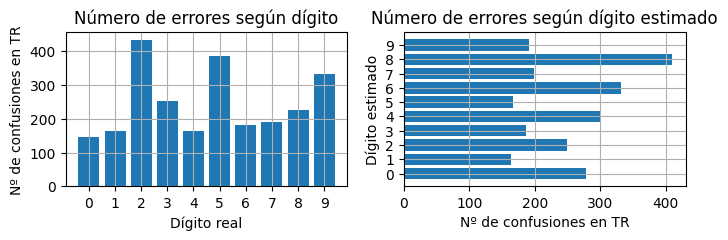

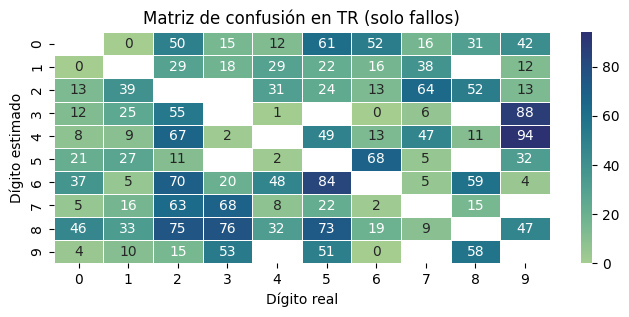

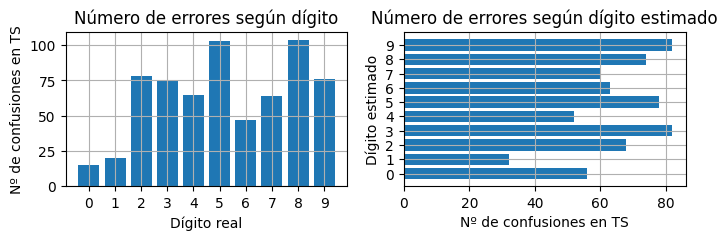

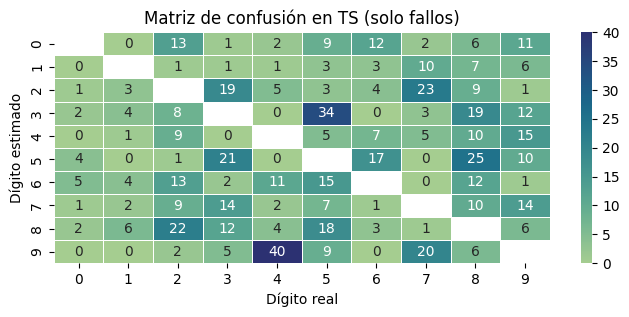

In [9]:
util_mlp_cnn_ESU23.calcula_aciertos_modelo(train_loader, model, 'TR')
util_mlp_cnn_ESU23.calcula_aciertos_modelo(test_loader, model, 'TS')

util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(train_loader, model, 'TR', 10)
util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(test_loader, model, 'TS', 10)

¿Por qué ha fallado?

In [10]:
# guardamos en un nuevo tensor todos los casos incorrectos
tr_err_img = torch.empty(1, 28*28, dtype=float)
tr_err_etq_real = torch.empty(1, 1, dtype=torch.uint8)
tr_err_etq_est = torch.empty(1, 1, dtype=torch.uint8)

with torch.no_grad():
    for i, (imgs, etqs) in enumerate(test_loader):
        imgs = imgs.reshape(-1, 28*28).to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)
        _, predictions = torch.max(outputs, 1)

        # cogemos los fallos
        ind_fallos = etqs != predictions

        tr_err_img = torch.cat((tr_err_img, imgs[ind_fallos]), dim=0)
        tr_err_etq_real = torch.cat((tr_err_etq_real, etqs[ind_fallos].unsqueeze(0)), dim=1)
        tr_err_etq_est = torch.cat((tr_err_etq_est, predictions[ind_fallos].unsqueeze(0)), dim=1)
        # print(tr_err_etq_real)
        # print(tr_err_etq_est)
        # print(tr_err_img)

print(tr_err_etq_real.size())
print(tr_err_etq_est.size())
print(tr_err_img.size())

torch.Size([1, 648])
torch.Size([1, 648])
torch.Size([648, 784])


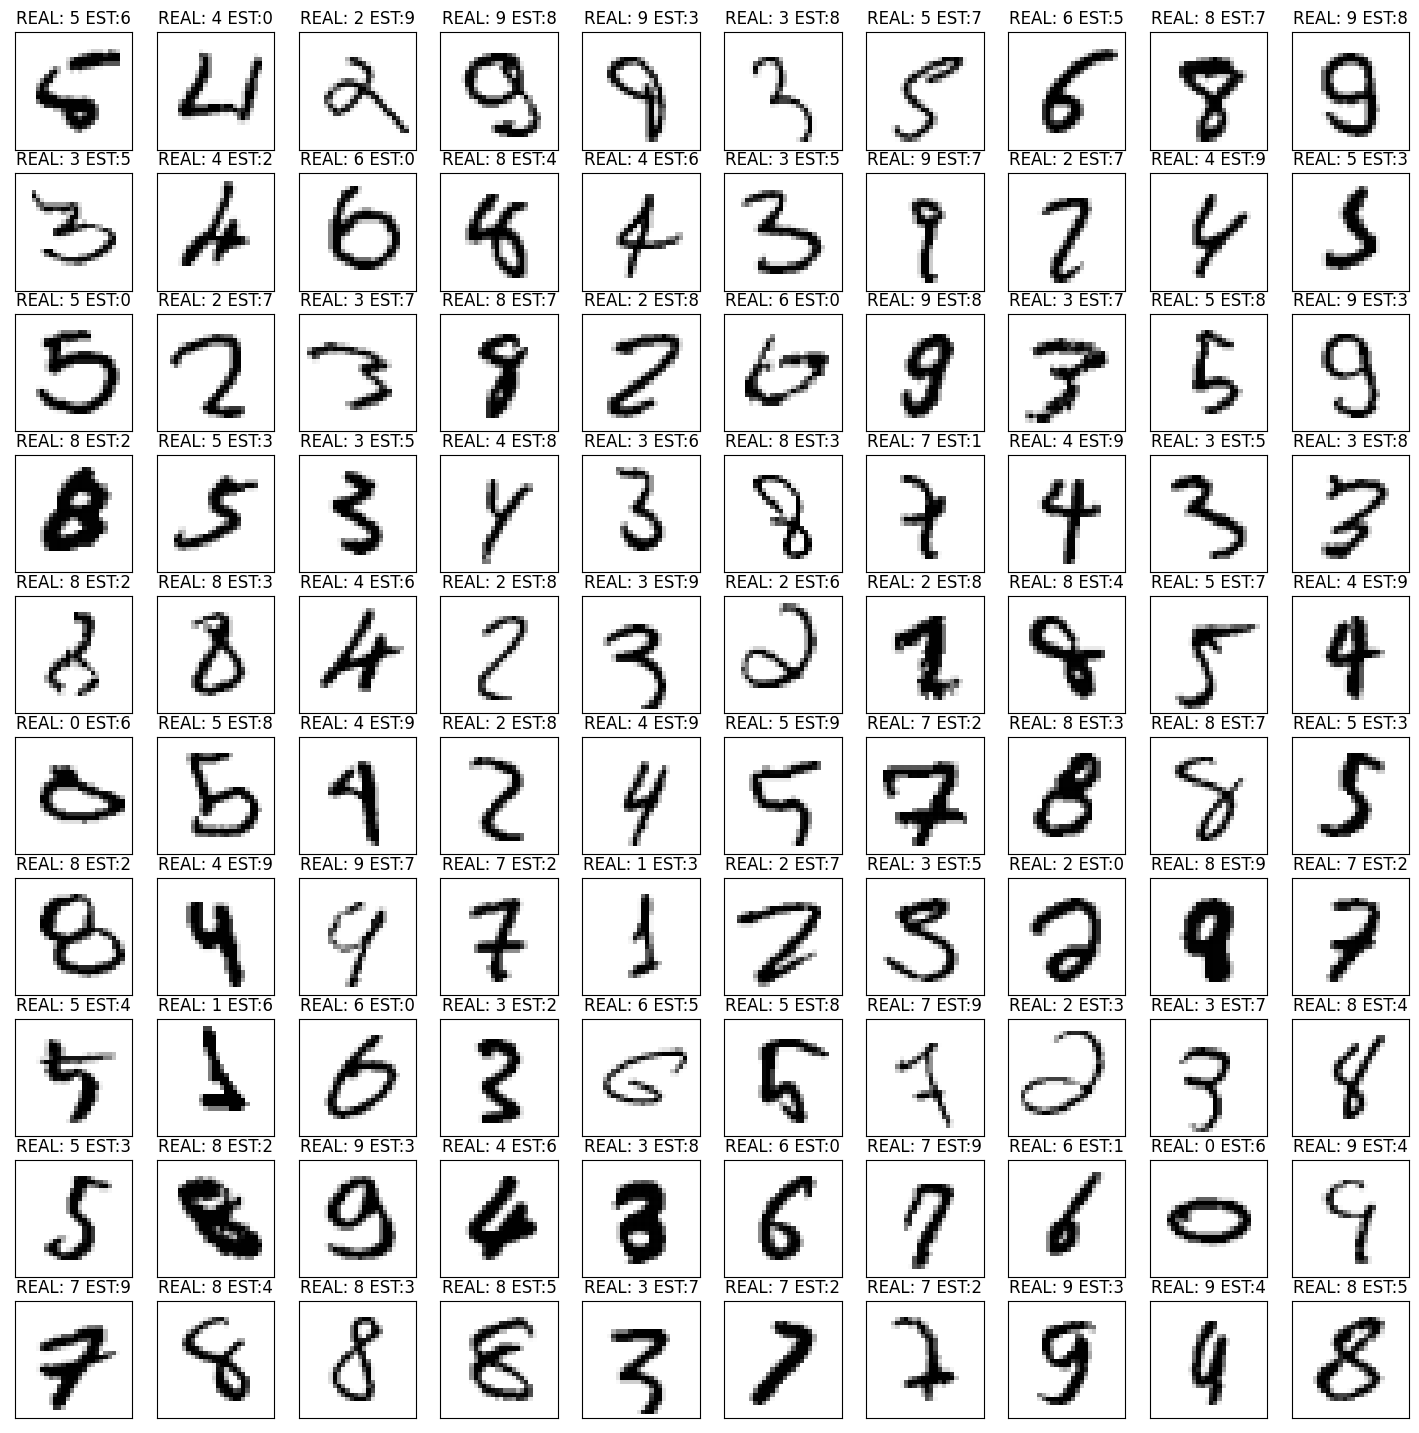

In [11]:
# pintamos unos cuantos fallos
fig = plt.figure(1,figsize=(18, 18))
k=1
for i in range(100):
    plt.subplot(10,10,k)
    plt.imshow(tr_err_img[i+1].reshape(28,28), cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'REAL: {tr_err_etq_real[0,i+1].item()} EST:{tr_err_etq_est[0,i+1].item()}')
    k = k+1

plt.show()

#### Almacenamos el modelo para utilizarlo luego

In [12]:
fecha_creacion = '2023_11_17'
torch.save(model.state_dict(), f'modelo_mlp_ajustado_{fecha_creacion}.pth')